In [ ]:
# 本次考虑一个单层的承压含水层。

# 假设一200m×100m的长方形，划分为20×10格，步长均为10m的网格区域。

# 网格区域左右两侧和下侧第10~16格为定水头边界（见下图波浪线区域），分别为1m3/d，4m3/d和3m3/d。

# 区内共有四口井，其坐标分别为：A(4, 4)，B(5, 10)，C(1, 15)，D(8, 18)，其中A和C为抽水井，抽水速率分别为500m3/d和300m3/d；B和D为补水井，补水速率分别为400m3/d和600m3/d。

# 区内垂直渗透系数均为10m/d，水平渗透系数分为四个区域，见下图四个色块所示。

# mf2005的建模顺序比较清晰，可归纳为：

# 创建模型；
# 设置模型的网格信息并建立离散化单元；
# 建立边界等信息；
# 建立含水层特性；
# 建立井信息；
# 输出控制；
# 写入mf2005，并运行模型。

In [1]:
import os
import numpy as np
import pandas as pd
import flopy
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

%config InlineBackend.figure_format = 'retina'
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
config = {
    'font.family':'Times New Roman',
    'font.size': 15,
    'font.serif': ['SimSun'],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'mathtext.fontset':'stix',
    'savefig.dpi':300,}
plt.rcParams.update(config)

In [2]:
temp_dir = TemporaryDirectory()
workspace = os.path.join(temp_dir.name)
print(workspace)

C:\Users\ART\AppData\Local\Temp\tmpxysdm3cq


In [3]:
# 1.创建模型

modelname = "mf2005Steadyflow"  # 模型名称

mf = flopy.modflow.Modflow(
    modelname,
    exe_name="mf2005",
    namefile_ext="nam",
    model_ws=workspace,
    version="mf2005",
)
# 生成了 mf2005Steadyflow 文件夹和 *.nam 文件


# 2.设置模型的网格信息并建立离散化单元；

Lx = 200.0  # x的长度
Ly = 100.0  # y的长度
ztop = 0.0  # z的顶部高程
zbot = -10.0  # z的底部高程
nlay = 1  # 含水层数量
nrow = 10  # x网格数
ncol = 20  # y网格数
delr = Lx / nrow  # x步长
delc = Ly / ncol  # y步长
delv = (ztop - zbot) / nlay  # z步长
botm = np.linspace(ztop, zbot, nlay + 1)

# botm可在z方向将研究区划分为若干个含水层/隔水层。在本例子中仅有一层，因此仅为 nlay+1。
# botm和top可以是单个浮点数，也可以是二维数组，用于描述每一含水层顶底板的高程变化。

# Discretization Input File (DIS) 离散化输入文件，参数分别是 模型名，层数，x格数，y格数，x，y密度，顶部高程，底部高程

dis = flopy.modflow.ModflowDis(
    mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:]
)

# botm[0]为top的值，因此从1开始计数


# 3.建立边界等信息；
# MODFLOW中的边界条件ibound共有三种状态，即<0，0，>0。
# ibound<0，表明是定水头的单元，通常用-1表示；
# ibound=0，表明是隔水单元；
# ibound>0，表明是活动单元，通常用1表示。

ibound = np.ones(
    (nlay, nrow, ncol), dtype=np.int32
)  # np.ones()函数是NumPy中的一个函数，它用于创建指定形状的数组，并将数组中的元素初始化为1。

ibound[:, :, 0] = -1

ibound[:, :, -1] = -1

ibound[:, -1, 10:16] = -1

strt = np.ones((nlay, nrow, ncol), dtype=np.float32)

strt[:, :, 0] = 1.0

strt[:, 0:9, -1] = 4.0

strt[:, -1, 10:16] = 3.0

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# 无论是 ibound，strt，以及渗透系数等单元信息，均为 [z, x, y] 的三维数组形式。


# 4.建立含水层特性；
# flopy.modflow.ModflowLpf 中的 laytyp 用于设置含水层的类型。
# laytyp=0，表明是承压含水层；

hk = np.ones((nlay, nrow, ncol), dtype=np.float32)

hk[:, :, 0:5] = 10.0

hk[:, 0:2, 5:10] = 1.0

hk[:, 2:7, 5:10] = 5.0

hk[:, 7:10, 5:10] = 2.0

hk[:, :, 10:20] = 8.0

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=10.0, ipakcb=53)

# laytyp (int or array of ints (nlay)) 默认为0，表明为承压含水层

# 0 confined >0 convertible <0 convertible unless the THICKSTRT option is in effect. (default is 0).# laytyp>0，表明是潜水含水层；

# laytyp<0，表明可转换。


# 5.建立井信息；

spd = {0: [[0, 8, 18, -500], [0, 4, 4, 400], [0, 5, 10, -300], [0, 1, 15, 600]]}

wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd)

# 井的信息利用字典进行储存，一个键值对代表了该应力周期内井的位置和抽/补水效率。

# 字典的键表示为不同的应力周期。由于本例中地下水是稳定流，因此只有一个键值对。

# 字典的值由两个列表包含而成，每一个子列表代表一口井，列表值的顺序是[z, x, y, 抽/补水]。


# 6.输出控制；

spd = {(0, 0): ["print head", "print budget", "save head", "save budget"]}

oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

pcg = flopy.modflow.ModflowPcg(mf)


# spd 依旧是一个字典，其键用元组展示，代表了应力周期和时间步长。

# 在同一个应力周期内，模型的边界等条件不会发生改变。时间步长则反映为在一个应力周期内划分模型在时间尺度上的间隔。应力周期和时间步长均在事先进行设置。

# 本例为稳定流，因此仅需设为 (0, 0)。

# flopy.modflow.ModflowPcg 用于对模型求解。


# 7.写入mf2005，并运行模型。

mf.write_input()

success, buff = mf.run_model()

if not success:
    raise Exception("MODFLOW did not terminate normally.")


# 本次模拟共生成以下文件：
# my_model.bas
# my_model.cbc
# my_model.dis
# my_model.hds
# my_model.list
# my_model.lpf
# my_model.nam
# my_model.oc
# my_model.pcg
# my_model.wel

FloPy is using the following executable to run the model: ..\..\flopy\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005Steadyflow.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/12/25 16:33:35

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/12/25 16:33:35
 Elapsed run time:  0.019 Seconds

  Normal termination of simulation


c:\Environment\MiniConda\envs\backend\lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


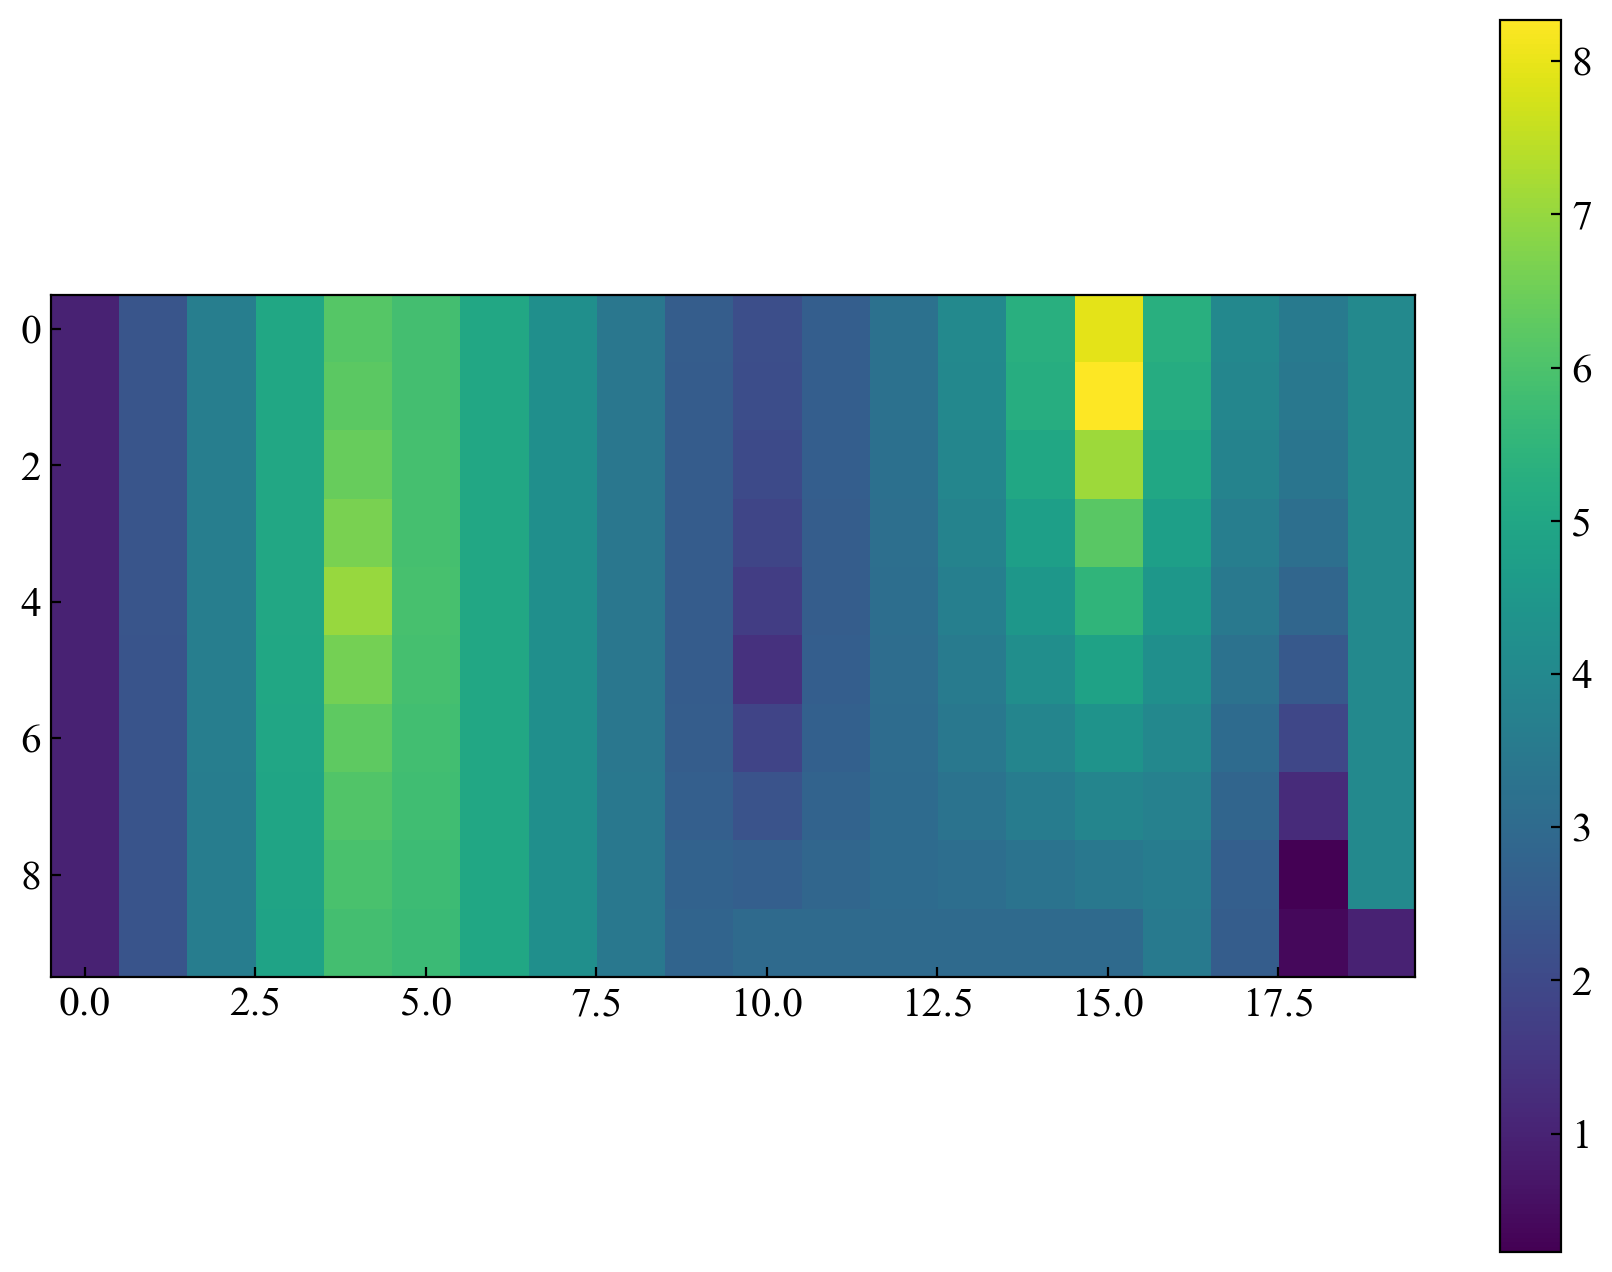

In [4]:
#可视化结果

#若绘制渗流场，需提取 *.hds 文件。
# 提取水头数据
hds = bf.HeadFile(workspace + '\\mf2005Steadyflow.hds')
head = hds.get_data(totim=1.0)
df = pd.DataFrame(head[0])
# print(df)
plt.figure(figsize=(11,8))
plt.imshow(df)
plt.colorbar()